# 🌳 Identify Spatial Neighbourhoods on Categorical Data (cell phenotypes)

In this  tutorial, we delve into the specifics of spatial analysis using categorical data, such as cell types or cluster assignments. We will guide you through two primary methods: `spatial_count` and `spatial_lda`, each offering a nuanced perspective on analyzing cellular arrangements within tissues. You'll learn not only to delineate and interpret neighborhoods but also to visualize them effectively. The tutorial culminates in exploring neighborhood-to-neighborhood correlations and interactions, equipping you with a comprehensive toolkit for spatial analysis in biological research.

In [1]:
# import packages
import scimap as sm
import anndata as ad

Running SCIMAP  1.3.14


In [2]:
# Load the data that we saved in the last tutorial (with ROIs added)
adata = ad.read_h5ad('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/scimapExampleData.h5ad')

The `spatial_count` approach is straightforward. For each cell, a local neighborhood is identified and normalized, resulting in a matrix that is subsequently utilized for clustering. This process defines the spatial neighborhoods.

### A. spatial_count approach

In [3]:
adata = sm.tl.spatial_count(adata, phenotype='phenotype', method='radius', radius=80, label='spatial_count')

Identifying neighbours within 80 pixels of every cell


After using the tool, the next step is to cluster the results. We'll do this with the `spatial_cluster` function. Make sure to check out the documentation to see all the different ways you can cluster. For now, we'll keep it simple and go with the k-means method.

In [4]:
# note that the df_name parameter needs to the same as the label used in the previous step.
adata = sm.tl.spatial_cluster(adata, df_name='spatial_count', method='kmeans', k=6, label='neigh_kmeans')

Kmeans clustering


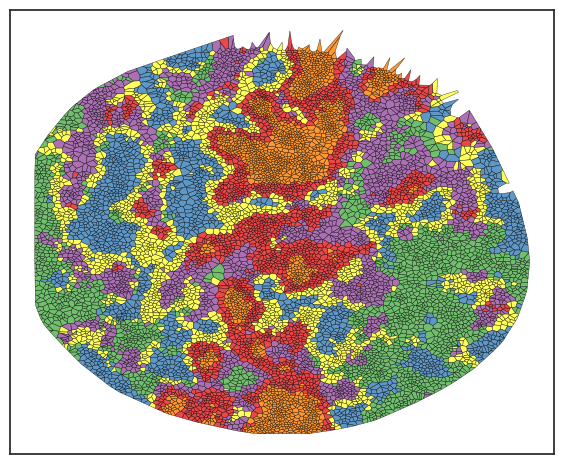

In [5]:
# Let's visualize the results.
sm.pl.voronoi(adata, color_by='neigh_kmeans', 
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0.3, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6)

In this example, I've chosen k=5 for clustering, but typically, I over-cluster the data and then group them into meta clusters. This approach helps ensure that no rare clusters are missed. To understand these neighborhoods, I examine the cell type composition within each one. When analyzing solid tumors, you'll often find a tumor neighborhood dominated by tumor cells, usually over 90%, and a tumor-stromal interface neighborhood that features a mix of tumor and stromal cells.

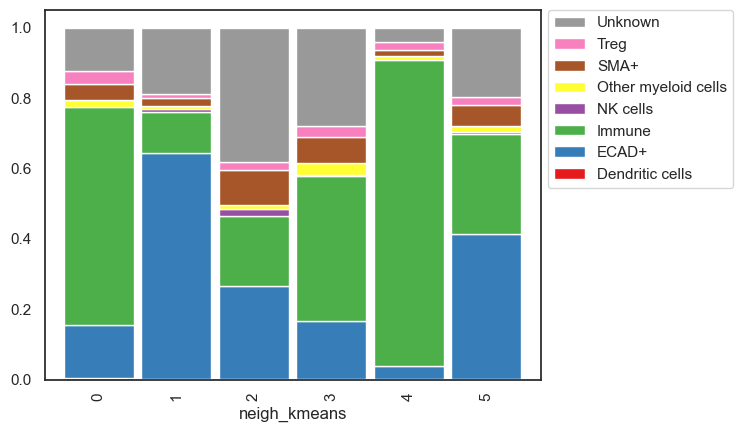

In [6]:
# Let's plot the composition of these neighbourhoods
sm.pl.stacked_barplot (adata, x_axis='neigh_kmeans', y_axis='phenotype')

While analyzing the clusters, the cell type distribution allows us to name each neighborhood. We won't do that here since we're working with demo data, but it's worth noting that naming is more straightforward with just 6 clusters. The challenge arises when dealing with 30 or 40 clusters. To address this, I employ several strategies for grouping them into meta clusters:

1. I use Plotly to create stacked bar plots, which offer added interactivity. This feature lets me toggle specific cell types on and off to examine their distribution across neighborhoods.
2. I also utilize Plotly for spatial scatter plots, adding another layer of interactivity. This helps in understanding distribution based on known histology. For example, if a cluster is localized to the skin's upper layer, it likely represents a structural unit like the epidermis. Note that while scimap doesn't natively support spatial scatter plots in Plotly, I'll share a script that enables this functionality.
3. Additionally, I analyze the correlation of cell type abundance across neighborhoods, aiding in grouping similar clusters together.

Below, you'll find demonstrations of these three approaches:

#### 1. stacked bar plot with plotly

In [7]:
# you will notice that the execution of this line will open a new tab in your web browser with the plot
sm.pl.stacked_barplot (adata, x_axis='neigh_kmeans', y_axis='phenotype', plot_tool='plotly')

#### 2. spatial scatter plot with plotly

In [8]:
# Vizualising using plotly
import pandas as pd
import plotly.express as px
import plotly.io as pio

def plotly (adata,phenotype,image_id=None,x='X_centroid',y='Y_centroid',size=2, **kwargs):
    if image_id is not None:
        adata = adata[adata.obs['imageid'] == image_id]    
    data = pd.DataFrame({'x':adata.obs[x], 'y':adata.obs[y],'col': adata.obs[phenotype]})
    data = data.sort_values(by=['col'])
    fig = px.scatter(data, x="x", y="y", color="col", **kwargs)
    fig.update_traces(marker=dict(size=size),selector=dict(mode='markers'),hoverlabel = dict(namelength = -1))
    fig.update_yaxes(autorange="reversed", tickformat='g')
    fig.update_xaxes(tickformat='g')
    fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)'})
    fig.show()

In [10]:
# you will notice that the execution of this line will open a new tab in your web browser with the plot
plotly (adata,phenotype='neigh_kmeans', size=8)

#### 3. Correlation plot to check which clusters are similar

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/plotting/groupCorrelation.py:127: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



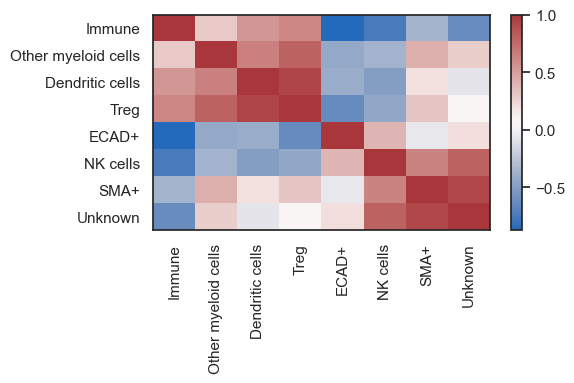

In [12]:
sm.pl.groupCorrelation(adata, groupBy='phenotype', condition='neigh_kmeans', figsize=(6,4))

After deciding which clusters to group together, use the rename function to add a new column that represents the consolidated neighborhoods.

In [13]:
# Consolidate clusters to neighborhoods

rename_dict = {'RCN1': ['1'],
               'RCN2': ['0', '4'],
                'RCN3': ['2'],
                'RCN4': ['3']}

adata = sm.hl.rename(adata, rename=rename_dict, from_column='neigh_kmeans', to_column='RCNs')

Renaming 1 to RCN1
Renaming 0 to RCN2
Renaming 4 to RCN2
Renaming 2 to RCN3
Renaming 3 to RCN4


/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/plotting/pie.py:149: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/plotting/pie.py:154: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



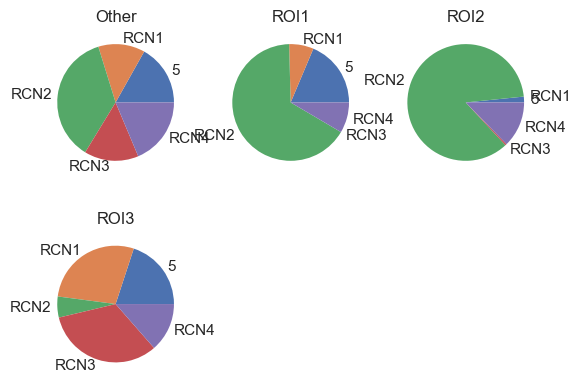

In [14]:
# Visualize the RCNs composition between patient groups (in this case ROIs as example)

sm.pl.pie(adata, phenotype='RCNs', group_by='ROI', ncols=3)

After defining the neighborhoods, all analyses previously applied to cell types can also be conducted on these neighborhoods. This includes calculating distances between neighborhoods, examining interaction patterns between and within neighborhoods, observing how these interactions vary across different neighborhoods, and analyzing fold changes in neighborhood abundance between ROIs or patient groups, among others. For guidance on executing these analyses, refer to other tutorials. The key point is that once the neighborhoods are established, a wide range of analytical possibilities becomes accessible.

### B. spatial_lda approach

The `sm.tl.spatial_lda` function constructs a neighborhood matrix utilizing categorical variables, such as cell types, designated by the user. It applies Latent Dirichlet Allocation (LDA) to explore the latent architecture of cellular distributions. This methodology produces weights that clarify the spatial configuration of cells, thus facilitating the identification of Recurrent Cellular Neighborhoods (RCNs). Generally, LDA is utilized for text data, aiming to cluster documents based on the frequency of word usage. It's important to note that, in contrast to text data, which may contain millions of unique words, our scenario typically involves a much smaller vocabulary—often between 5 to 20 cell types. This limited "vocabulary" can prevent the LDA model from converging. Therefore, rather than directly utilizing the output of the LDA model, we extract latent variables post-training and cluster these to define cellular neighborhoods. This approach adapts the LDA model, commonly used for text, to effectively analyze cellular spatial distributions.

In [15]:
# run the LDA tool
adata = sm.tl.spatial_lda(adata, method='radius', radius=80, label='spatial_lda')

Processing: ['exemplar-001--unmicst_cell']
Identifying neighbours within 80 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.35570971537759294
Gathering the latent weights


In [16]:
# note that the df_name parameter needs to be the same as the label used in the previous step.
adata = sm.tl.spatial_cluster(adata, df_name='spatial_lda', method='kmeans', k=6, label='spatial_lda_kmeans')

Kmeans clustering


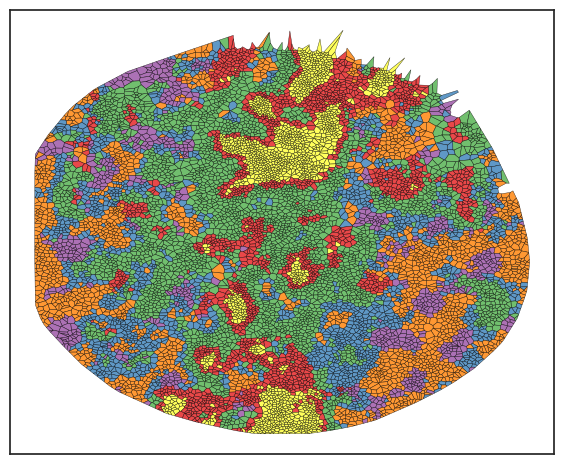

In [17]:
# Let's visualize the results.
sm.pl.voronoi(adata, color_by='spatial_lda_kmeans', 
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0.3, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6)

As observed, some neighborhoods resemble those identified earlier by the `count` method. No single method suits all datasets, so it's advisable to experiment with both methods and determine which yields the best results, particularly in light of known positive controls within the data, such as distinct tissue structures. 

Once neighborhoods have been defined, the downstream processes remain consistent with what was previously described—endeavor to discern the significance of each neighborhood, compare them across different image/ patient groups, and formulate your hypothesis accordingly.

### Save Results

In [18]:
# Save the results
adata.write('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/scimapExampleData.h5ad')